!["rain"](rain.jpeg)

# Raincouver (in progress)

While I claim that Vancouver, BC has the best weather (and best most other things) in Canada, one thing that it is known for is rain. Perhaps this is the price we pay for avoiding consistent 30&deg;C summers and -20&deg;C winters. Given this is the case one thing that can be useful living here is trying to figure out when the rain usually happens and how it behaves in general. If we have a working modelof how rain in Vancouver happens, then we can answer questions like how likely is it to rain tomorrow or when is the rainy season. Famous statistician George Box once said "All models are wrong, but some are useful." Here we aim to build a useful one. If I could be build a model that was not wrong, then I would be rich, but alas modelling weather has proven to be a hard task for centuries.

## Building a Dataset


Luckily, weather data is accessable to the public via the federal government. Unluckily, it is not some nice dataset and is instead reported in an inconsistent format and has tons of missing values. This makes sense though as they probably didn't care as much about "big data applications"  in 1930s.

In [1]:
%%sh
cd /Users/alansmacbook/Desktop/Learning/Raincouver/data;
for year in `seq 1926 2021`; do
    if ! [ -e "en_climate_daily_BC_1108446_${year}_P1D.csv" ]; then
        wget --content-disposition "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=888&Year=${year}&timeframe=2&submit= Download+Data";
    fi;
done;

for year in `seq 1962 2021`; do
    if ! [ -e "en_climate_daily_BC_1105669_${year}_P1D.csv" ]; then
        wget --content-disposition "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=833&Year=${year}&timeframe=2&submit= Download+Data";
    fi;
done;

for year in `seq 2013 2021`; do
    if ! [ -e "en_climate_daily_BC_1108395_${year}_P1D.csv" ]; then
        wget --content-disposition "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51442&Year=${year}&timeframe=2&submit= Download+Data";
    fi;
done;

for year in `seq 1977 2021`; do
    if ! [ -e "en_climate_daily_BC_1106PF7_${year}_P1D.csv" ]; then
        wget --content-disposition "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=837&Year=${year}&timeframe=2&submit= Download+Data";
    fi;
done;

In order to deal with the missing values (which we will take a look at below), we will get data from four different weather stations around Metro Vancouver. The four are annotated below on a map of vancouver with their official name as follows.


| Marker |  Station Name  |
| --- | ---  |
| 1 |  VANCOUVER HARBOUR CS |
| 2 |  N VANCOUVER WHARVES |
| 3 |  VANCOUVER INTL A |
| 4 |  RICHMOND NATURE PARK |

!["map"](map_annotated.png)

In [88]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import tqdm
import itertools
import multiprocessing
import sys
import os
import time


In [3]:
data_dir = "/Users/alansmacbook/Desktop/Learning/Raincouver/data/"
stations =  ["VANCOUVER HARBOUR CS", "N VANCOUVER WHARVES", "VANCOUVER INTL A", "RICHMOND NATURE PARK"]
csv_files = [f for f in os.listdir(data_dir) if f[0] != "."]
frames = []
for file in csv_files:
    frames.append(pd.read_csv(data_dir + file))
weather_data = pd.concat(frames)
weather_data.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)',
       'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)',
       'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag',
       'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)',
       'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag'],
      dtype='object')

Several of these columns I do not particularly care  about for rain purposes, but we will keep a few that are not stricly relevant in case we want to do any other analysis later. I am also going reset the index to be ordered based on the "Date/Time" Column to ensure that this is indeed time series data up to station (which we will deal with later).

In [4]:
weather_data = weather_data.drop(columns=
                ['Longitude (x)', 
                'Latitude (y)', 
                'Climate ID',
                'Max Temp Flag', 
                'Min Temp Flag',
                'Mean Temp Flag', 
                'Heat Deg Days (°C)', 
                'Heat Deg Days Flag',
                'Cool Deg Days (°C)',
                'Cool Deg Days Flag',
                'Snow on Grnd (cm)',
                'Snow on Grnd Flag', 
                'Dir of Max Gust (10s deg)',
                'Dir of Max Gust Flag', 
                'Spd of Max Gust (km/h)',
                'Spd of Max Gust Flag'])

weather_data = weather_data.sort_values("Date/Time").reset_index(drop=True)

In [5]:
weather_data.head(10)

,Station Name,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag
0,VANCOUVER HARBOUR CS,1926-01-01,1926,1,1,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,VANCOUVER HARBOUR CS,1926-01-02,1926,1,2,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,VANCOUVER HARBOUR CS,1926-01-03,1926,1,3,NaN,NaN,NaN,NaN,3.0,NaN,0.0,NaN,3.0,NaN
3,VANCOUVER HARBOUR CS,1926-01-04,1926,1,4,NaN,NaN,NaN,NaN,4.3,NaN,0.0,NaN,4.3,NaN
4,VANCOUVER HARBOUR CS,1926-01-05,1926,1,5,NaN,NaN,NaN,NaN,46.5,NaN,0.0,NaN,46.5,NaN
5,VANCOUVER HARBOUR CS,1926-01-06,1926,1,6,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
6,VANCOUVER HARBOUR CS,1926-01-07,1926,1,7,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
7,VANCOUVER HARBOUR CS,1926-01-08,1926,1,8,NaN,NaN,NaN,NaN,0.3,NaN,0.0,NaN,0.3,NaN
8,VANCOUVER HARBOUR CS,1926-01-09,1926,1,9,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
9,VANCOUVER HARBOUR CS,1926-01-10,1926,1,10,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN


We can merge the data for each year, drop some columns we we won't be dealing with, and sort chronologically. When Looking at the data I noticed many empty entries, so I wanted to get an idea of how bad the problem is. Some records are specifically flagged  as missing in the Total Rain Flag column, but there appear to be other values that are empty and unflagged despite having positive total precipitation (which is rain plus snow).

In [6]:
def analyzeMissing(station_data):
    total_records = len(station_data)
    missing_records = station_data[station_data["Total Rain (mm)"].isnull()]
    flagged_missing_records = station_data[station_data["Total Rain Flag"] == "M"]
    records_minus_flagged = station_data[station_data["Total Rain Flag"] != "M"]
    station_name = station_data['Station Name'].unique()[0]
    print(f"Station Name: {station_name}")
    print(f"Total Records: {total_records}")
    print(f"Total Missing Records: {len(missing_records)}")
    print(f"Flagged Missing Records: {len(flagged_missing_records)}")
    print(f"Percent Missing: {100*round(len(missing_records)/total_records,4)}%")
    plt.figure(figsize=(15,5))
    plt.bar(x=missing_records["Year"].unique(), height=missing_records.groupby("Year").count()["Day"])
    plt.title(f"Days Missing Per Year at {station_name}")

Station Name: VANCOUVER HARBOUR CS
Total Records: 35064
Total Missing Records: 13525
Flagged Missing Records: 4328
Percent Missing: 38.57%


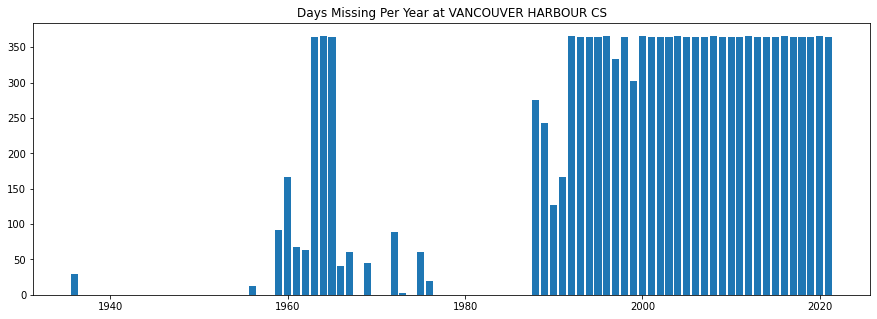

In [7]:
analyzeMissing(weather_data[weather_data["Station Name"] == stations[0]])

Station Name: N VANCOUVER WHARVES
Total Records: 21915
Total Missing Records: 2180
Flagged Missing Records: 56
Percent Missing: 9.950000000000001%


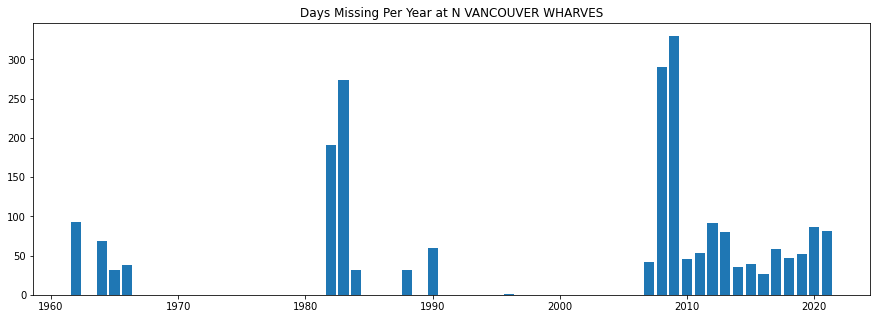

In [8]:
analyzeMissing(weather_data[weather_data["Station Name"] == stations[1]])

Station Name: VANCOUVER INTL A
Total Records: 3287
Total Missing Records: 205
Flagged Missing Records: 35
Percent Missing: 6.239999999999999%


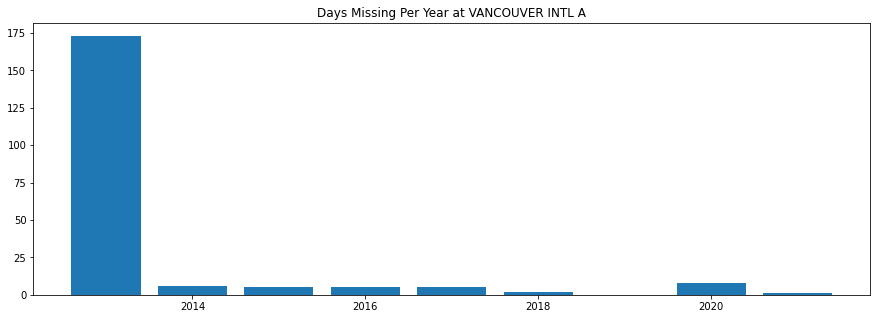

In [9]:
analyzeMissing(weather_data[weather_data["Station Name"] == stations[2]])

Station Name: RICHMOND NATURE PARK
Total Records: 16436
Total Missing Records: 932
Flagged Missing Records: 42
Percent Missing: 5.67%


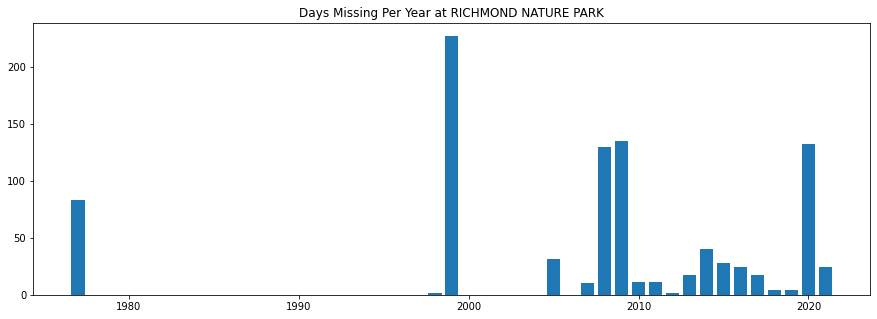

In [10]:
analyzeMissing(weather_data[weather_data["Station Name"] == stations[3]])

So unfortunatly not only is there a lot of missing data, the system being used to flag this data is inconsistent as well. Given this, I am going to ignore the flag column and just treat all missing values as the same. To get a more accurate picture of when it does rain, I will make a simplifying assumption that if it rains at at least one of the stations we are looking at then it has rained in Vancouver. With this assumption we can combine the four stations data to fill in where each other have missing data. In the case that multiple measurments exist, I would like to aggregate with the mean, but I first am going to check for any outlier values at each station so that the mean does not adversely influence any of the aggregations. Annoyingly PyPlot's BoxPlot doesn't have an option to ignore NaN values so we will have to remove those manually.

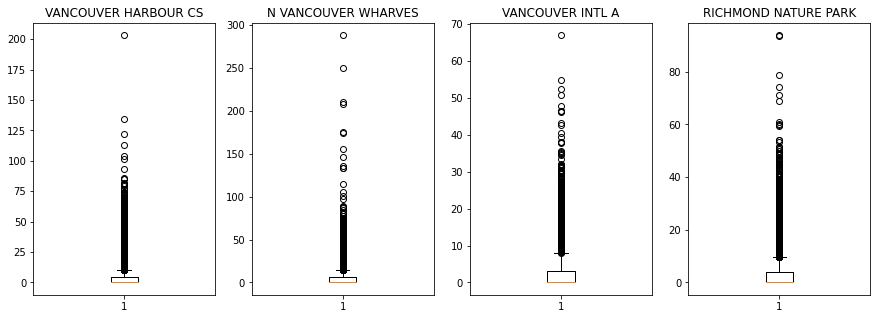

In [11]:
plt.figure(figsize=(15,5))
for i, station  in enumerate(stations):
    station_rain = weather_data[weather_data["Station Name"] == station]["Total Rain (mm)"]
    filtered_station_rain = station_rain[~station_rain.isna()]
    plt.subplot(1,4,i+1)
    plt.title(stations[i])
    plt.boxplot(filtered_station_rain)

In [12]:
summaries = []
for i, station  in enumerate(stations):
    summaries.append(weather_data[weather_data["Station Name"] == station]["Total Rain (mm)"].rename(station).describe())
summaries = pd.concat(summaries, axis=1)
summaries

,VANCOUVER HARBOUR CS,N VANCOUVER WHARVES,VANCOUVER INTL A,RICHMOND NATURE PARK
count,21539.000000,19735.000000,3082.000000,15504.000000
mean,3.964307,4.890565,3.158014,3.381760
std,8.638749,10.342854,6.555007,6.813287
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.200000
75%,4.100000,5.800000,3.200000,3.800000
max,203.200000,288.200000,67.000000,93.800000


Looking at the boxplots and summary statistics, there are clearly some very large values that traditionally one could consider outliers, but in this case I think the data makes sense. For example, the stations that have more records  have higher maximums, which would be consistent with more observations under the assumption that these large observations are less likley (which I think is a realistic assumption). The standard deviation is relativly low as well  which suggests that a significant portion of the data lies close to the mean. Given these observations I am comfortable taking mean across shared observations to combined the data. We will do so by grouping by the data and aggregating the rain column.

Total Records: 35064
Total Missing Records: 732
Percent Missing: 2.09%


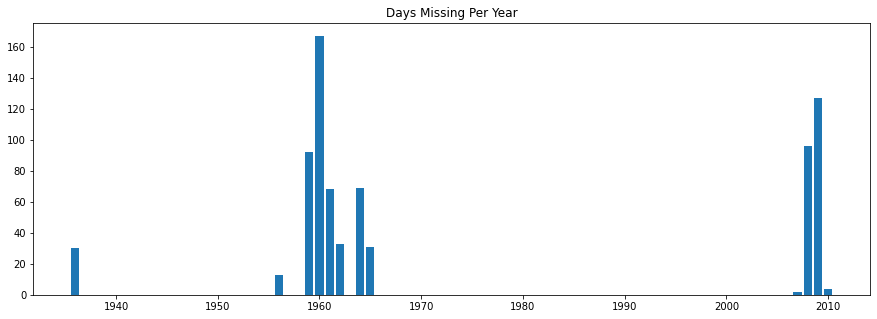

In [13]:
merged_rain_data = weather_data.groupby(["Year", "Month", "Day"]).mean()["Total Rain (mm)"].reset_index()
total_records = len(merged_rain_data)
missing_records = merged_rain_data[merged_rain_data["Total Rain (mm)"].isnull()]
print(f"Total Records: {total_records}")
print(f"Total Missing Records: {len(missing_records)}")
print(f"Percent Missing: {100*round(len(missing_records)/total_records,4)}%")
plt.figure(figsize=(15,5))
plt.bar(x=missing_records["Year"].unique(), height=missing_records.groupby("Year").count()["Day"])
plt.title("Days Missing Per Year")
plt.show()

Now we are looking in quite a bit better shape. There are still some missing data, particularly around the 1960s and 2010s, which I would like to take a look at and see if we can make any decent assumptions about that data.

In [14]:
def missingYearsMap(start_year, end_year):
    assert start_year <= end_year
    year_range = range(end_year, start_year - 1, -1)
    plt.figure(figsize=(20,end_year - start_year))
    X = np.zeros((len(year_range),355))
    for i in year_range:
        X[i - min(year_range),:] = merged_rain_data[merged_rain_data["Year"] == i]["Total Rain (mm)"].isna()[0:355]
    plt.title(f"Missing data from {start_year} to {end_year}")
    plt.xlabel("Day")
    plt.ylabel("Year")
    plt.yticks(ticks=np.arange(end_year - start_year + 1)[::-1], labels=year_range)
    plt.imshow(X, interpolation='nearest', aspect='auto')
    plt.show()

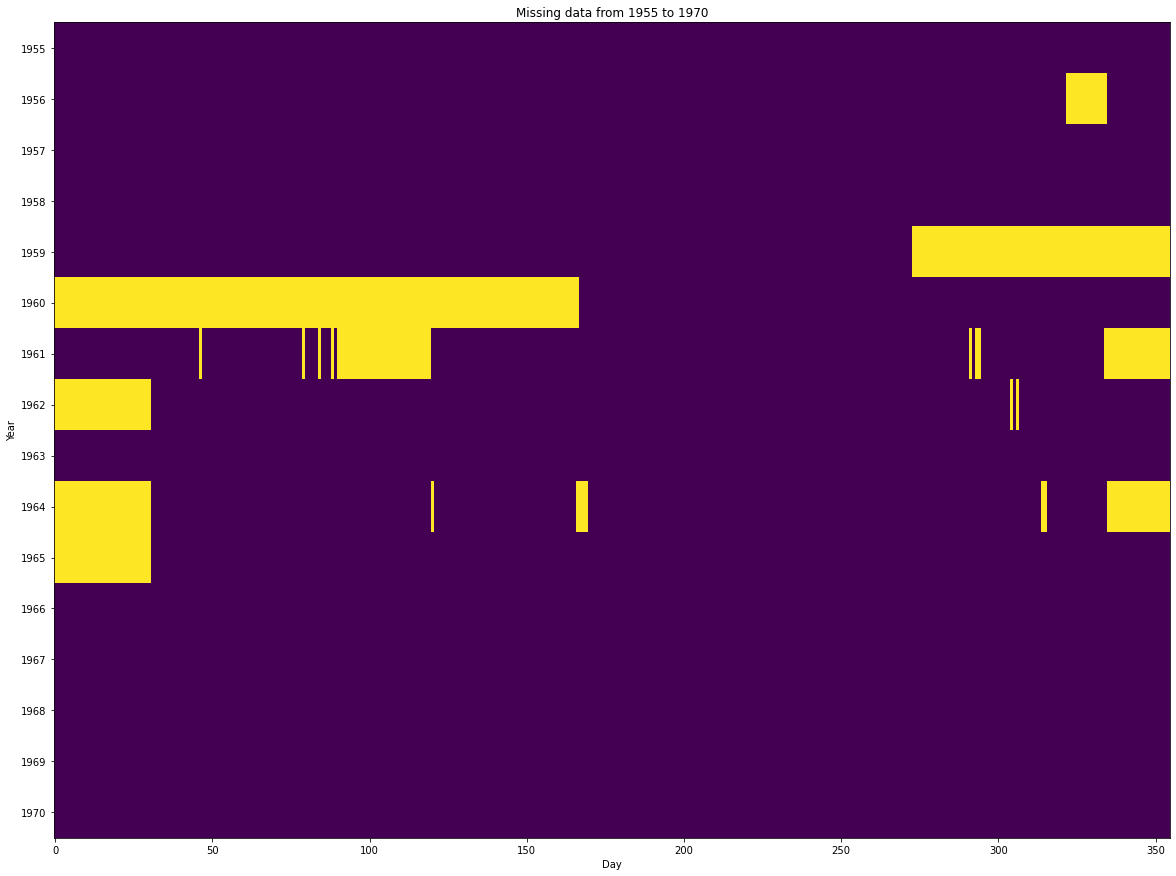

In [15]:
missingYearsMap(1955,1970)

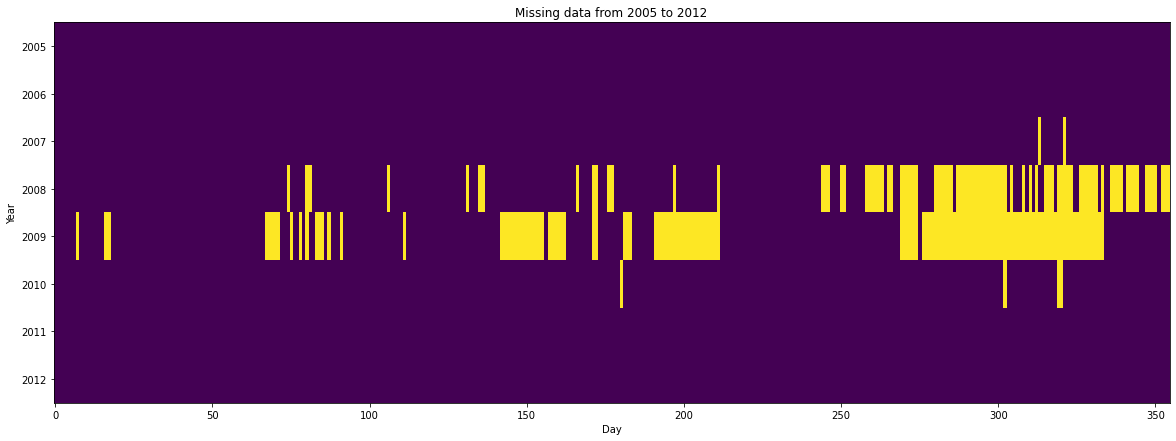

In [16]:
missingYearsMap(2005,2012)

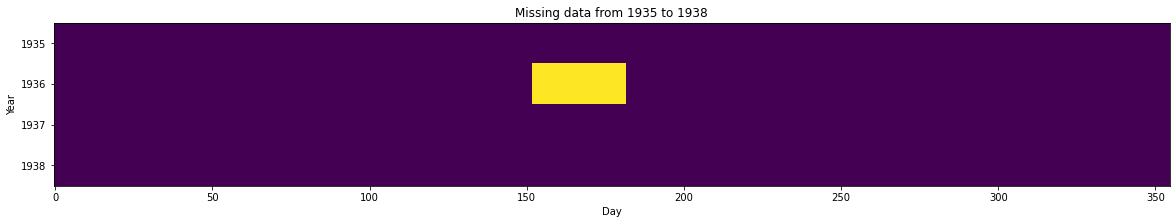

In [17]:
missingYearsMap(1935,1938)

So now we have a much clearer picture of what exactly the remaining missing data looks like. Here we are going to have to make some tough decisions on what to do. Two of the years (2007, 2010) have only a couple missing records and they are isolated, so I am comfortable interpolating those values with a cubic spline and calling it a day. For the remaining years this approach would be  somewhat problematic given that  we have several long stretches (often months) where there iz no data recorded. This would lend poorly to using interpolation so I suspect we would get very inaccurate estimates. There are other methods that we could use such as replacing the missing data with the average of their day or month or something (imputation) or if we want to get really fancy using some form of Expectation Maximization (EM). However, I am hesitant to use these given that in the full time series (across all years) the data is not independent. If we wanted to just consider individual years or months this may be okay, but when we consider the full time series it is problematic. For this reason I've elected to drop the years 1936, 1956, 1959, 1960, 1961, 1962, 1964, 1965, 2008, and 2009 from the dataset for when we consider the full time series from 1926 to 2021. If we want model months or years independently, then it may be possible to use methods like imputation so I will keep the missing years around, but from here on will call the "Complete Dataset" the one with no missing values and the "Partial Dataset" as the data including the above years.

In [18]:
bad_years = [1936, 1956, 1959, 1960, 1961, 1962, 1964, 1965, 2008, 2009]

PartialDataset  = merged_rain_data
CompleteDataset = merged_rain_data[merged_rain_data["Year"].map(lambda x: x not in bad_years)].reset_index(drop=True)
CompleteDataset = CompleteDataset.interpolate(method="cubicspline")

print(f"Missing Records in Complete Dataset: {len(CompleteDataset[CompleteDataset['Total Rain (mm)'].isnull()])}")


Missing Records in Complete Dataset: 0


## Some Exploratory Data Analysis

I thought it would be interesting to pick out a few record of the most and least rain before do anything too series.

#### Years with Least Rain

In [19]:
CompleteDataset.drop(["Month", "Day"], axis=1).groupby("Year").sum().sort_values("Total Rain (mm)").head(10)

,Total Rain (mm)
Year,
1929,904.600000
1985,991.633333
1952,1093.400000
2002,1103.200000
1987,1134.666667
1943,1137.400000
2019,1146.200000
1957,1152.100000
1930,1157.200000


In [20]:
CompleteDataset.drop(["Month", "Day"], axis=1).groupby("Year").sum().sort_values("Total Rain (mm)", ascending=False).head(10)

,Total Rain (mm)
Year,
2017,2011.750000
1974,1926.200000
1968,1872.200000
1997,1872.166667
1972,1870.950000
1975,1823.850000
1931,1822.800000
1966,1815.850000
1932,1806.500000


#### Average Rain by Month

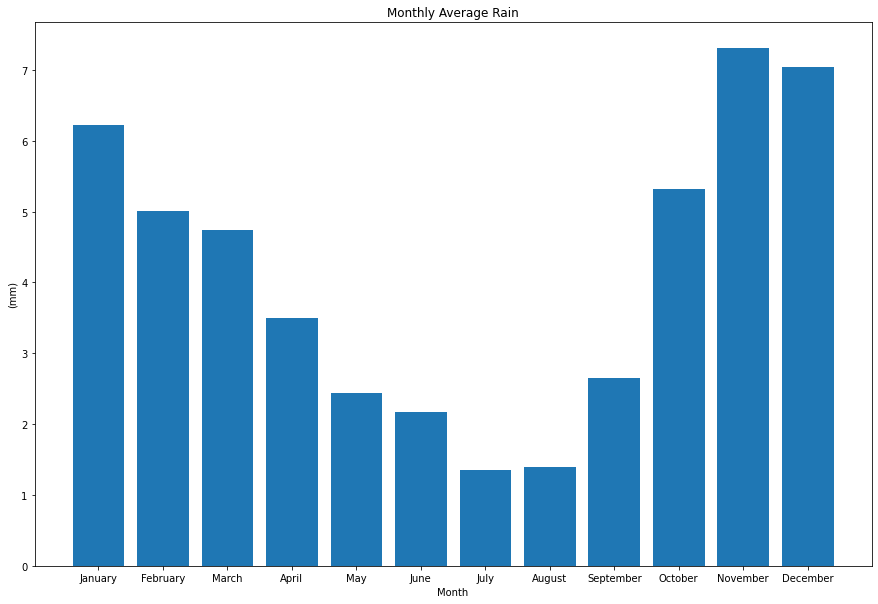

In [21]:
plt.figure(figsize=(15,10))
yearly_average = CompleteDataset.drop(["Year", "Day"], axis=1).groupby("Month").mean()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.bar(x=yearly_average.index.to_numpy(), height=yearly_average["Total Rain (mm)"].to_numpy(), label = "Per Year Average Rain")
plt.title("Monthly Average Rain")
plt.ylabel("(mm)")
plt.xlabel("Month")
plt.xticks(ticks=yearly_average.index.to_numpy(), labels=months)
plt.show()

#### Average Rain  Across the Years

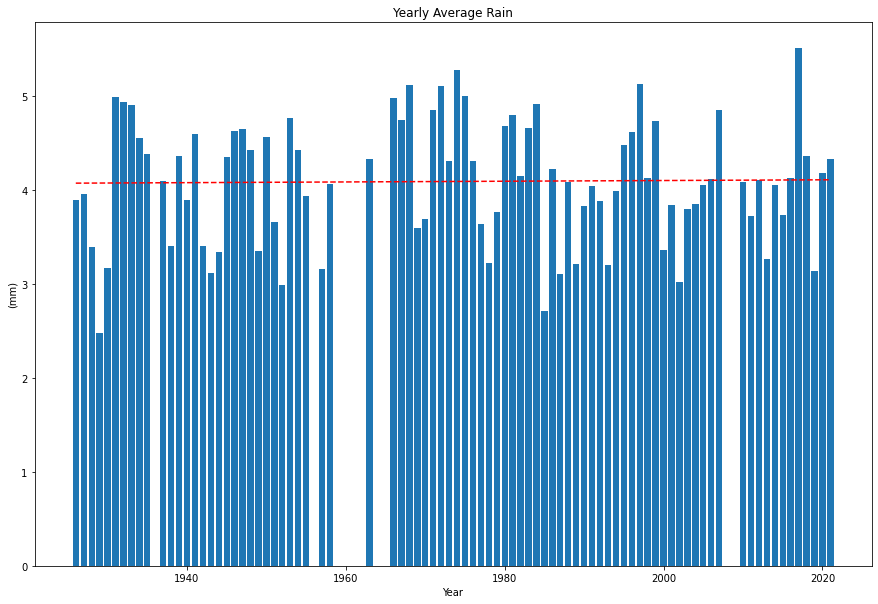

In [22]:
plt.figure(figsize=(15,10))
yearly_average = CompleteDataset.drop(["Month", "Day"], axis=1).groupby("Year").mean()
a, b = np.polyfit(yearly_average.index.to_numpy(), yearly_average["Total Rain (mm)"].to_numpy(), 1)
plt.bar(x=yearly_average.index.to_numpy(), height=yearly_average["Total Rain (mm)"].to_numpy(), label = "Per Year Average Rain")
plt.plot(yearly_average.index.to_numpy(), a*yearly_average.index.to_numpy()+b, "--", color="red")
plt.title("Yearly Average Rain")
plt.ylabel("(mm)")
plt.xlabel("Year")
plt.show()

Recalling that the major gaps in the above visualizaiton are from where we had to drop some years, it appears that the average yearly rain is increasing very slightly but is fairly constant. If I had to guess maybe the  positive trendline has to do with global warming.

## Modeling the Rain

To start things off, we are going to consider the question of "Did it/Will it rain?" rather than "How much will it rain?" The latter can be studied with many of the same methods as I'm going to talk about up to a few adjustments. For todays quesiton, we will need to change the dataset slightly from how much it rained to a binary variable. I'm going to make the (somewhat arbitrary) decision that if it rained at least one millimeter, then it rained in Vancouver. This could be adjusted without changing any of the methodology.

In [23]:
RainedDataset = CompleteDataset.copy()
RainedDataset["Total Rain (mm)"] = (CompleteDataset["Total Rain (mm)"] > 1.0)
RainedDataset = RainedDataset.rename(columns={"Total Rain (mm)":"Rained"})

While we are here, I am going to cut the data  up into  a  couple different  numpy friendly matrices of varying time periods. This will help  modelling different time periods.

In [24]:
X = RainedDataset.to_numpy(dtype=np.int8)
XYears = np.stack([RainedDataset[RainedDataset["Year"] == y]["Rained"].to_numpy(dtype=np.int8)[0:355] for y in RainedDataset["Year"].unique()])
month_years = itertools.product(RainedDataset["Year"].unique(),RainedDataset["Month"].unique())
XMonths =  np.stack([RainedDataset[(RainedDataset["Year"] == y)  & (RainedDataset["Month"] == m)]["Rained"].to_numpy(dtype=np.int8)[0:28] for y, m in month_years])

In [165]:
def rainMap(X, start_date=0, figsize=(20,10)):
    if X.ndim == 1:
            X =  X[:,None].T
    N,T = X.shape
    X = ~X
    plt.figure(figsize=figsize)
    plt.title(f"Rain Heat (Cool?) Map")
    plt.xlabel("Day")
    plt.ylabel("Sample")
    plt.yticks(ticks=np.arange(N), labels=range(start_date, start_date+N))
    plt.xticks(ticks=np.arange(0,T,10))
    plt.imshow(X, interpolation='nearest', aspect='auto', cmap='coolwarm')
    plt.show()

In [194]:
def probabilityMap(mat):
    fig, ax = plt.subplots()
    if mat.ndim == 1:
        y,x =  mat.size, 1
        plt.imshow(mat[:,None],interpolation='nearest', aspect='auto', cmap='YlOrRd')
    else:
        y,x =  mat.shape
        plt.imshow(mat,interpolation='nearest', aspect='auto', cmap='YlOrRd')
    plt.xticks(range(x))
    plt.yticks(range(y))
    ax.xaxis.tick_top()
    plt.show()

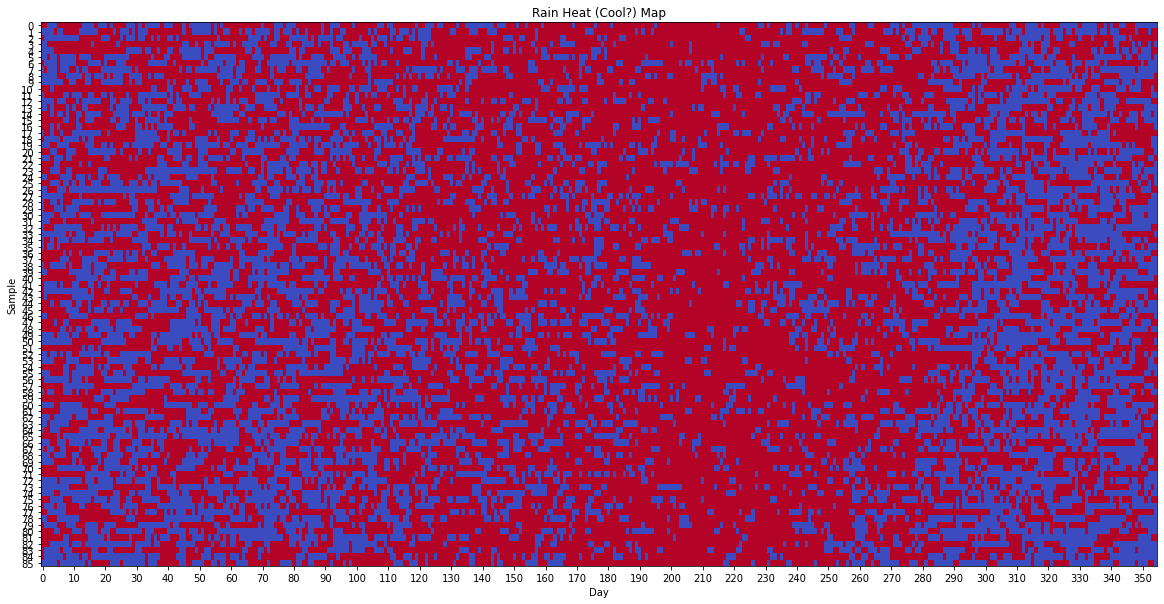

In [185]:
rainMap(XYears)

#### Flipping a Coin

Probably the simplest model one can think of if we want to sample rainy or not rainy days is just treat every day we have as independent and decide how likley it is to be rainy based on that. This can be characterized as a Bernoulli random variable, which is really just flipping a weighted coin. This model completely forgets that this is a time series, so no matter how I cut up the data (months, years, weeks, etc.) if I use one model I will get the same result. That said, you could make different Bernoullis for different time periods, but then we would essentially be forgetting about all the other data during that time period. Lets give this model a try.

Probability of rain: 0.3872911889944317
Negative Log Liklihood of Training Data: 236.96994360250687


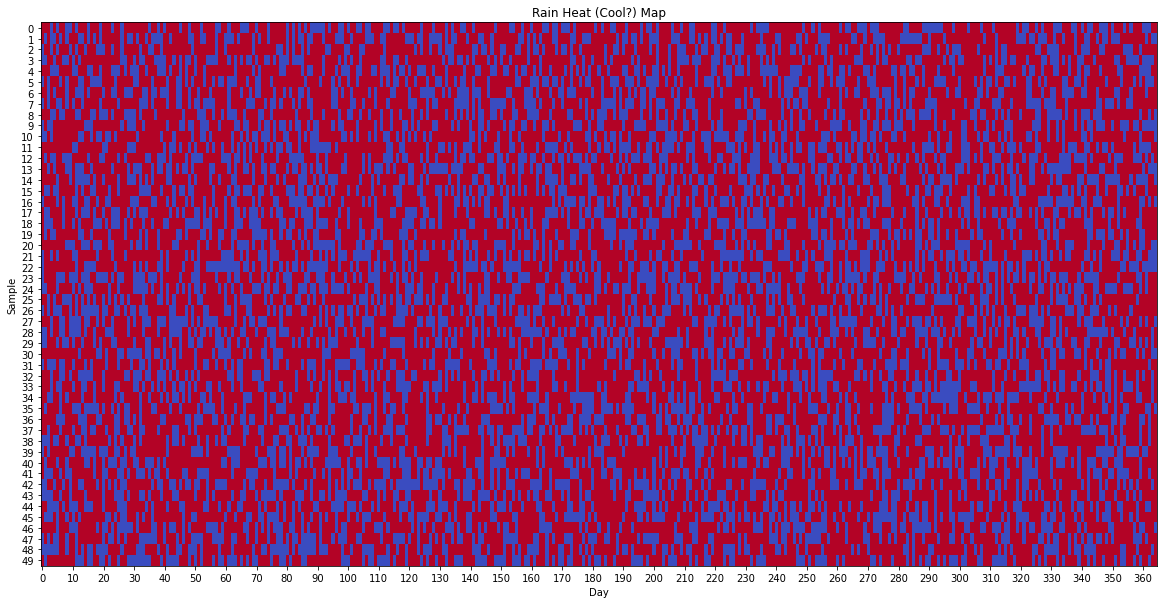

In [179]:
RainBernoulli = Bernoulli(XYears)
BernoulliSamples = RainBernoulli.sample(365,50)
rainMap(BernoulliSamples)

So this looks fairly random with a slight bias towards not rain. While it makes sense we would see this given the assumptions of the model, it's clearly not  very realistic as often we will have rainy weeks or sunny weeks or in general similar weather comes at the same times.

#### Markov Chains

Clearly whether it rains on any given day is not independent on the surrounding days. For example if there was a giant storm yesterday there is a better chance there is still a giant storm today then if it  was sunny yesterday. Noting this, we can try to incorporate "what happened yesterday" using a Markov Chain. This model uses a (still fairly strong) assumption that given what happened yesterday, wether it rains tomorrow is independent of two days ago and three days ago any number of days prior to yesterday. This is often refered to as conditional independence.

![mc](chain.png)

Negative Log Liklihood of Training Data: 258.57125816957824


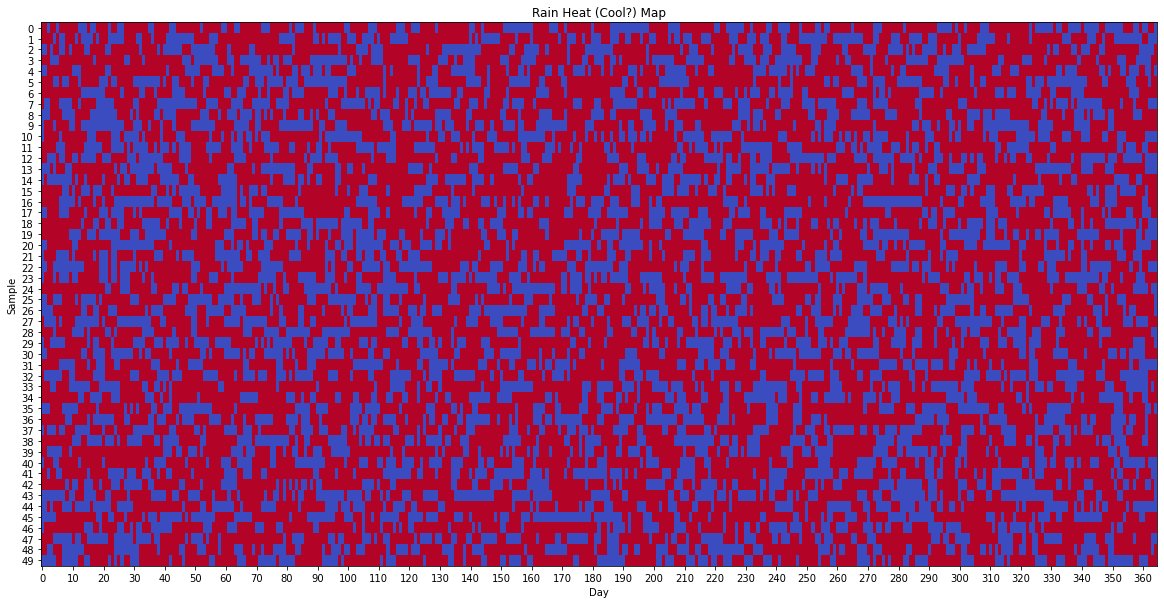

In [178]:
RainChain = MarkovChain(XYears)
MCSamples = RainChain.sample(365,50)
rainMap(MCSamples)

This looks somewhat better as we can see there is clearly some dependence inbetween days. Non-rain days are more likely to be followed by   rain days and  the same  for rain days. One thing  we can note is that the Negative Log Likelyhood (NLL) is actually higher  here than for the Bernoulli model. This  is odd but can happen due  to overfitting or a variety of other reasons. Here "domain knowledge" that days are dependent on each other is probably more valuable than blindly trusing in the NLL. All that being said, we know that the Markov assumption (today only depends on yesterday) is a very strong one and rarely true in practice. We can further relax this with the following assumption.

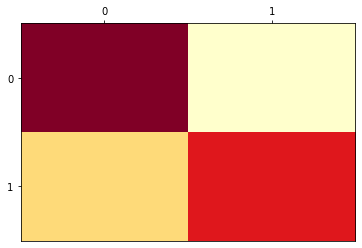

array([[0.77, 0.23],
       [0.36, 0.64]])

In [132]:
probabilityMap(RainChain.P)
np.round(RainChain.P, decimals=2)

#### Hidden Markov Models

Hidden Markov Models (HMMs) are a very powerful class of models where we see observations (in this case whether it rained) but those observations are dependent on some sort of "hidden state" that we do not observe. For example, a colleague of  mine  works on tracking whales that  have radio transponders attached to them. The measurements they get   are innacurate, but  depend  on the true location of the whale. So, the radio signals are the observations and the whales true location is the hidden  state we cannot see. With the rain data, the state _could_ be something like  seasons, but it's  a bit dicey when we try  to interpret the learned hidden states. They are learned with the Baum-Welch Algorithm which is a special case of Expectation Maximization, and are not necessarily unique or optimal. The algorithm is maximizing a lower bound to a non-convex objective, so in general training can be difficult and a hard to reproduce. That said, HMMs are a very powerful model class.

![hmm](hmm.png)

In [164]:
RainHMM = HMM(XYears, d_hidden=4, maxiters=2000)

100%|█████████▉| 1992/2000 [34:30<00:08,  1.02s/it]

Iterations Taken to Fit: 1999
Final Delta Value: 0.00042548024405851857
Negative Log Liklihood of Training Data: 202.0588519310559


100%|██████████| 2000/2000 [34:31<00:00,  1.04s/it]


Iterations Taken to Fit: 1999
Final Delta Value: 0.00023603915148027294


100%|█████████▉| 1999/2000 [34:31<00:00,  1.04it/s]

Negative Log Liklihood of Training Data: 202.08346512945747


100%|██████████| 2000/2000 [34:32<00:00,  1.04s/it]


Iterations Taken to Fit: 1999
Final Delta Value: 0.00018760032843569908


100%|█████████▉| 1994/2000 [34:32<00:05,  1.06it/s]

Negative Log Liklihood of Training Data: 202.48096523720812


100%|██████████| 2000/2000 [34:34<00:00,  1.04s/it]


Iterations Taken to Fit: 1999
Final Delta Value: 0.00021977969822160155
Negative Log Liklihood of Training Data: 202.06355634453647


100%|██████████| 2000/2000 [34:37<00:00,  1.04s/it]


Iterations Taken to Fit: 1999
Final Delta Value: 5.4676100816596394e-05
Negative Log Liklihood of Training Data: 200.6735226330627


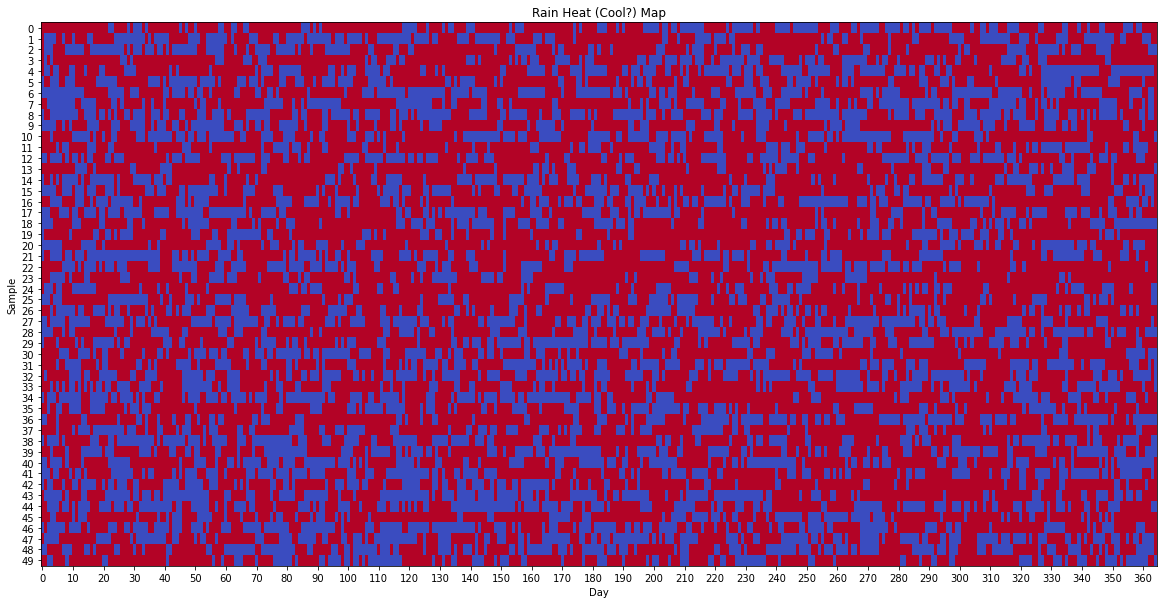

In [166]:
rainMap(RainHMM.sample(365,50))

So here with  four hidden states, we get a much  better NLL  and  we can see there are certain stretches in the data with little to no rain, and others with  significant chunks of rain. If I had to guess (again this  is  questionable), the HMM has learned  during the  summer for example there is very  little rain and during the winter this  is the opposite.

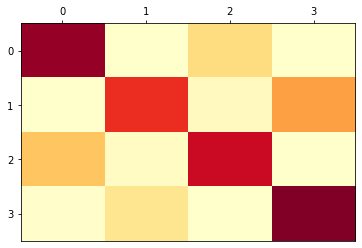

array([[0.81, 0.  , 0.19, 0.  ],
       [0.  , 0.6 , 0.03, 0.37],
       [0.27, 0.03, 0.71, 0.  ],
       [0.  , 0.15, 0.  , 0.85]])

In [167]:
probabilityMap(RainHMM.P)
np.round(RainHMM.P, decimals=2)

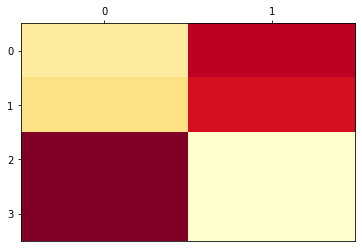

array([[0.13, 0.87],
       [0.2 , 0.8 ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [168]:
probabilityMap(RainHMM.O)
np.round(RainHMM.O, decimals=2)

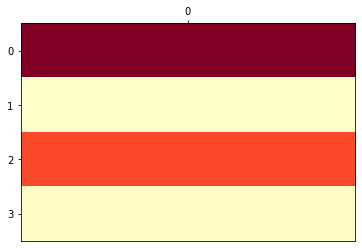

array([0.61, 0.  , 0.38, 0.01])

In [169]:
probabilityMap(RainHMM.pi)
np.round(RainHMM.pi, decimals=2)

In [181]:
RainHMM10 = HMM(XYears, d_hidden=10)

100%|██████████| 1000/1000 [17:25<00:00,  1.05s/it]


Iterations Taken to Fit: 999
Final Delta Value: 0.002230759353779974
Negative Log Liklihood of Training Data: 200.2554161679145


100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it]


Iterations Taken to Fit: 999
Final Delta Value: 0.0013299058150991884
Negative Log Liklihood of Training Data: 200.38297654132924


100%|██████████| 1000/1000 [17:28<00:00,  1.05s/it]


Iterations Taken to Fit: 999
Final Delta Value: 0.002639910100323211


100%|█████████▉| 998/1000 [17:28<00:01,  1.10it/s]

Negative Log Liklihood of Training Data: 200.48237243945812


100%|██████████| 1000/1000 [17:29<00:00,  1.05s/it]


Iterations Taken to Fit: 999
Final Delta Value: 0.002248624174856745
Negative Log Liklihood of Training Data: 200.37101178908492


100%|██████████| 1000/1000 [17:35<00:00,  1.06s/it]


Iterations Taken to Fit: 999
Final Delta Value: 0.001269593048937668
Negative Log Liklihood of Training Data: 200.06922941754317


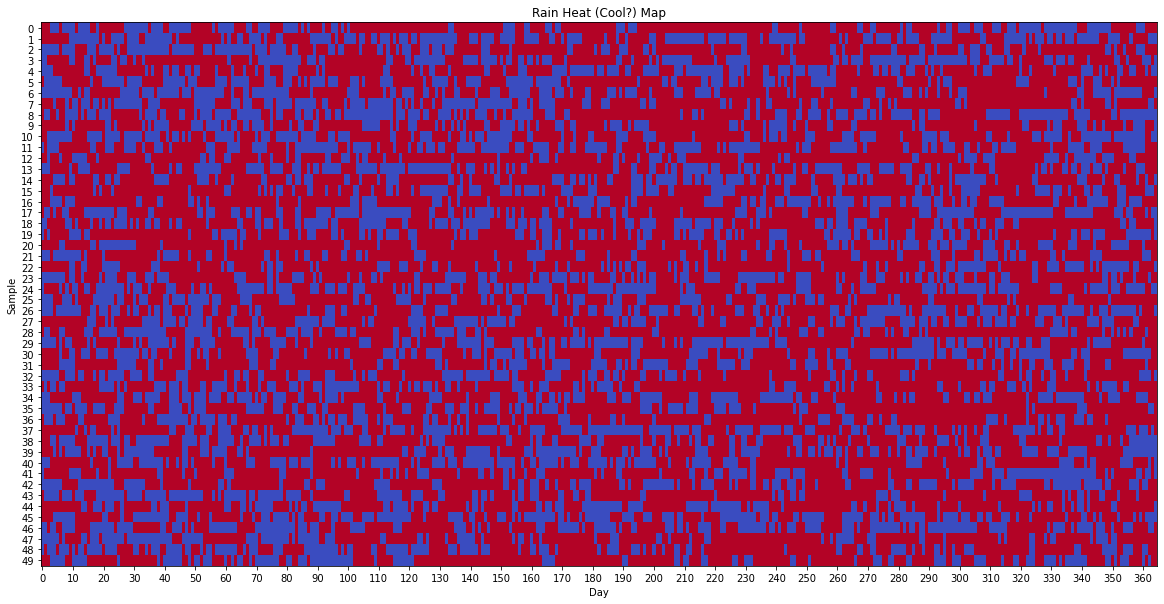

In [182]:
rainMap(RainHMM10.sample(365,50))

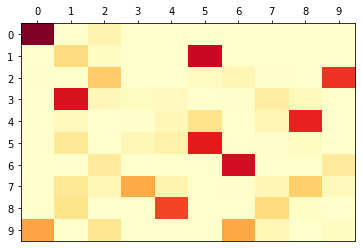

In [183]:
probabilityMap(RainHMM10.P)

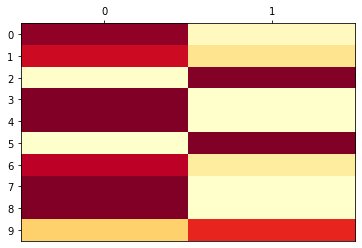

In [184]:
probabilityMap(RainHMM10.O)

## So is it going  to  rain  tomorrow?

Well realistically we can't know, weather forecasting has always been  a  very  challenging   task as it's a  highly complex system with tons of unknown  variables and stochasticity. But, we  can  use the models we have  built to make a best guess.

### Bernoulli:  I don't care about what  has already happened

With a bernoulli model, we are treating each  day as independent, so I can  say there is a 38.7\% chance of it raining tomorrow. I  probably wouldn't trust  this more than  my eyes.

### Markov Chain: What did it do yesterday?

Now  at least we care a little bit about what has already  happened, and we have a closed form solution given the  data. If it didn't rain yesterday there is a 33\% chance it will rain tomorrow, and if it  did rain  yesterday  there is  a 64\%  chance  it will rain tomorrow.


### Hidden  Markov Model: How many days  can  you give me?

With more  data, the HMM  can get a better guess as to what the  hidden  state is today, and  using that you can  get better estimates of what happens tomorrow by summing  across the  cluster-emmision probabilities  weighted by the estimates  of  what  the hidden state today  is. We can see an example of this below. We can  see that the most recent  day  has the largest influence (which makes sense), but  the HMM will take into account how many day it has already rained or not, or  other  weather  patters that are  hard for us   to interpret.

In [190]:
RainHMM.predictTomorrow(np.array([0,0,0,0,1]))

array([0.32029915, 0.67970085])

In [191]:
RainHMM.predictTomorrow(np.array([1,1,1,1,1]))

array([0.29639333, 0.70360667])

In [192]:
RainHMM.predictTomorrow(np.array([0,0,1,0,0]))

array([0.72677525, 0.27322475])

## Model Zoo

### Bernoulli Models

In [28]:
class Bernoulli():
        
        def __init__(self, X):
            self.p, self.q = self.fit(X)
        
        # returns p, the probability of rain
        def fit(self, X):
            X_flat = X.flatten()
            ratio = np.bincount(X_flat, minlength=2)/X.size
            print(f"Probability of rain: {ratio[1]}")
            print(f"Negative Log Liklihood of Training Data: {self._score(X, ratio[1], ratio[0])}")
            return ratio[1], ratio[0]
        
        def sample(self, length, nsamples=1):
            samples = np.zeros((nsamples,length), dtype=np.int64)
            for i in range(nsamples):
                for j in range(length):
                    samples[i,j] =  np.random.choice(2,1,p=[self.q, self.p])
            return samples
        
        def _score(self, X, p, q):
            N, T = X.shape
            X = X.flatten()
            log_prob  = 0.0
            for i in range(X.size):
                log_prob -= np.log(p if X[i] else q)
            return log_prob/N
        
        def score(self, X):
            return self._score(X, self.p, self.q)

### Markov Chains

In [29]:

class MarkovChain():
    
    def __init__(self, X, d_state=2):
        self.P, self.pi = self.fit(X,d_state)
        self.d = d_state

    def fit(self, X, d_state):
        if X.ndim == 1:
            X =  X[:,None].T
        N,T = np.shape(X)
        P = np.zeros((d_state,d_state), dtype=np.float64)
        pi = np.bincount(X[:,0], minlength=d_state)/N
        transitions = np.bincount(X[:,0:T-1].flatten())
        for i in range(d_state):
            for j in range(d_state):
                P[i,j] = np.sum([np.sum((X[:,t] == i) & (X[:,t+1] == j)) for t in range(T-1)])
            P[i] /= transitions[i]
        print(f"Negative Log Liklihood of Training Data: {self._score(X, pi, P)}")
        return P, pi
    
    def sample(self, length, nsamples=1):
        samples = np.zeros((nsamples,length), dtype=np.int64)
        for i in range(nsamples):
            samples[i,0] = np.random.choice(self.d,p=self.pi)
            for j in range(1,length):
                samples[i,j] = np.random.choice(self.d,p=self.P[samples[i,j-1]])
        return samples
    
    def chapmanKolmogorov(self, time, initial=None):
        marginals = np.zeros((self.d,time), dtype=np.float64)
        marginals[:,0] = initial if initial is not None else self.pi
        for i in range(1,time):
            marginals[:,i] = self.P.T @ marginals[:, i - 1]
        return marginals
    
    
    def marginals(self, time, method='exact', nsamples=10000):
        if method == 'exact':
            return self.chapmanKolmogorov(time)[:,time-1]
        elif method == 'Monte Carlo':
            samples =  self.sample(time,nsamples)
            return np.bincount(samples[:,time-1],  minlength=self.d)/nsamples
        else:
            raise ValueError("Method not recognized.")

    def forwardConditionals(self, posterior_time, condition_time,  condition_value, method='exact', nsamples=10000):
        assert condition_value < self.d
        assert condition_time <= posterior_time
        if method == 'exact':
            one_hot = np.zeros(self.d)
            one_hot[condition_value] = 1.0
            return self.chapmanKolmogorov(posterior_time - condition_time + 1, initial=one_hot)[:,posterior_time - condition_time]
        elif method == 'Monte Carlo':
            samples = self.sample(posterior_time, nsamples)
            filtered_samples = samples[samples[:, condition_time - 1] == condition_value]
            print(f"{np.shape(filtered_samples)[0]/nsamples}% of {nsamples} samples were rejected.")
            return np.bincount(filtered_samples[:,posterior_time - 1], minlength=self.d)/np.shape(filtered_samples)[0]
        else:
            raise ValueError("Method not recognized.")
    
    def backwardConditionals(self, posterior_time, condition_time,  condition_value, method='exact', nsamples=10000):
        assert condition_value < self.d
        assert condition_time >= posterior_time
        if method == 'exact':
            M = self.chapmanKolmogorov(condition_time)
            V = np.zeros_like(M)
            V[condition_value, condition_time - 1] = 1.0
            for i in range(condition_time - 1, 0, -1):
                V[:,i-1] = self.P @ V[:,i]
            MV = M*V
            return MV[:, posterior_time -  1]/np.sum(MV[:, posterior_time -  1])
        elif method == 'Monte Carlo':
            samples = self.sample(condition_time, nsamples)
            filtered_samples = samples[samples[:, condition_time - 1] == condition_value]
            print(f"{np.shape(filtered_samples)[0]/nsamples}% of {nsamples} samples were rejected.")
            return np.bincount(filtered_samples[:,posterior_time - 1], minlength=self.d)/np.shape(filtered_samples)[0]
        else:
            raise ValueError("Method not recognized.")

    def decode(self, time):
        M = np.zeros((self.d,time), dtype=np.float64)
        B = np.zeros((self.d,time), dtype=np.int64)
        M[:,0] = self.pi
        for i in range(1,time):
            for j in range(self.d):
                transition = [M[k,i-1]*self.P[k,j] for k in range(self.d)]
                M[j,i] = np.max(transition)
                B[j,i] = np.argmax(transition)
        prob = np.max(M[:,time-1])
        decoding = np.zeros(time, dtype=np.int64)
        decoding[time-1] = np.argmax(M[:,time-1])
        for i in range(time - 1, 0, -1):
            decoding[i-1] = B[decoding[i], i]
        return decoding, prob
    
    def _score(self, X, pi, P):
        if X.ndim == 1:
            X =  X[:,None].T
        log_prob = 0.0
        N, T = np.shape(X)
        for i in range(N):
            log_prob -= np.log(pi[X[i,0]])
            for j in range(1,T):
                log_prob -= np.log(P[X[i - 1, j],X[i,j]])
        return log_prob/N
        
    def score(self, X):
        return self.score(X, self.pi, self.P)
    

### Hidden Markov Models

In [195]:
class HMM():
    
    def __init__(self, X, d_hidden=4, d_emission=2, maxiters=1000, processes=5):
        self.d = d_emission
        self.h = d_hidden
        
        with multiprocessing.Pool(processes=processes) as p:
            candidates = p.starmap(self.fit, [(X,d_hidden,d_emission,maxiters) for _ in range(processes)])
            
        best_nll = np.inf
        for pi, P, O in candidates:
            candidate_nll = self._score(X, pi, P, O)
            if candidate_nll < best_nll:
                best_nll = candidate_nll
                self.pi, self.P, self.O = pi, P, O

    # Baum-Welch algorithm
    def fit(self, X, d_hidden, d_emission,  maxiters=1000, eps=1.0e-8):
        if X.ndim == 1:
            X = X[:,None].T
        N, T = np.shape(X)
        
        np.random.seed((os.getpid() * int(time.time())) % 20001005)
        pi = np.random.uniform(0, 1, d_hidden)
        P  = np.random.uniform(0, 1, (d_hidden,d_hidden))
        O  = np.random.uniform(0, 1, (d_hidden, d_emission))
        delta = np.inf
        for i in tqdm.tqdm(range(maxiters)):
            gamma = np.zeros((N, T, d_hidden), dtype=np.float64)
            xi = np.zeros(((N, T-1, d_hidden, d_hidden)), dtype=np.float64)
            
            for r in range(N):
                sample = X[r]
                alpha = self.forward(sample, pi, P, O)
                beta = self.backward(sample, pi, P, O)               
                gamma[r] = (alpha*beta)/np.sum((alpha*beta), axis=1)[:,None]
                for t in range(T-1):
                    xi[r,t] = alpha[t][:,None]*P*beta[t+1]*O[:,sample[t+1]]
                    xi[r,t] /= np.sum(xi[r,t])
            
            pi_new = (1/N)*np.sum(gamma[:,0], axis=0)
            P_new  = np.sum(xi, axis=(0,1))/np.sum(gamma[:,:-1], axis=(0,1))[:,None]
            O_new = O
            for o in range(d_emission):
                filtered_gamma = gamma[X == o]
                O_new[:,o] = np.sum(filtered_gamma, axis=0)/np.sum(gamma, axis=(0,1))
                
            delta = np.linalg.norm(pi - pi_new) + np.linalg.norm(P - P_new) + np.linalg.norm(O - O_new)
            pi, P, O = pi_new, P_new, O_new    
            
            if delta < eps:
                break
        
        print(f"Iterations Taken to Fit: {i}")
        print(f"Final Delta Value: {delta}")
        print(f"Negative Log Liklihood of Training Data: {self._score(X, pi, P, O)}")
        return pi, P, O
    
    def forward(self, sample, pi, P, O):
        T = sample.size
        alpha = np.zeros((T, self.h), dtype=np.float64)
        alpha[0] = pi*O[:,sample[0]]
        for t in range(T-1):
            alpha[t+1] = O[:,sample[t+1]]*(P.T @ alpha[t])
        return alpha
    
    def backward(self, sample, pi, P, O):
        T = sample.size
        beta = np.zeros((T, self.h), dtype=np.float64)
        beta[T-1, :] = 1.0
        for t in range(T-2,-1,-1):
            beta[t] = P @ (beta[t+1]*O[:,sample[t+1]])
        return beta
    
    def bayesianFilter(self, sample):
        alpha = self.forward(sample, self.pi, self.P, self.O)
        beta = self.backward(sample, self.pi, self.P, self.O)
        gamma = (alpha*beta)/np.sum((alpha*beta), axis=1)[:,None]
        return gamma[-1]
    
    def predictTomorrow(self, sample):
        p_x_t0 = self.bayesianFilter(sample)
        p_x_t1 = self.P.T @ p_x_t0
        p_y_t1 = np.sum(p_x_t1[:,None]*self.O, axis=0)
        return p_y_t1
    
    def decode(self, sample):
        time = sample.size
        M = np.zeros((self.h,time), dtype=np.float64)
        B = np.zeros((self.h,time), dtype=np.int64)
        M[:,0] = self.pi*self.O[:, sample[0]]
        for t in range(1,time):
            for j in range(self.h):
                transition = [M[k,t-1]*self.P[k,j]*self.O[k, sample[sample[t]]] for k in range(self.h)]
                M[j,t] = np.max(transition)
                B[j,t] = np.argmax(transition)
        prob = np.max(M[:,time-1])
        decoding = np.zeros(time, dtype=np.int64)
        decoding[time-1] = np.argmax(M[:,time-1])
        for t in range(time - 1, 0, -1):
            decoding[t-1] = B[decoding[t], t]
        return decoding, prob
    
    def sample(self, length, nsamples=1):
        samples = np.zeros((nsamples,length), dtype=np.int64)
        for i in range(nsamples):
            z = np.random.choice(self.h,p=self.pi)
            samples[i,0] = np.random.choice(self.d, p=self.O[z])
            for j in range(1,length):
                z = np.random.choice(self.h,p=self.P[z])
                samples[i,j] = np.random.choice(self.d, p=self.O[z])
        return samples
    
    def _score(self, X, pi, P, O):
        if X.ndim == 1:
            X =  X[:,None].T
        log_prob = 0.0
        N, T = np.shape(X)
        for i in range(N):
            sample = X[i]
            alpha = self.forward(sample, pi, P, O)
            log_prob -= np.log(np.sum(alpha[-1]))
        return log_prob/N

    def score(self, X):
        return self._score(X, self.pi, self.P, self.O)

    

In [203]:
# !["baumwelch"](baumwelch.png)


SyntaxError: invalid syntax (<ipython-input-203-f15f9b005c3a>, line 3)

In [ ]:

# TODO
class VRNN(torch.nn.Module):
    
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def sample(self):
        pass
    
    def predict(self):
        pass


### stuff to do 


Markov chain:

Fit per year

Fit per month

Fit per season

Fit across all data

Time inhomogeneous per day (data permitting)

Maybe higher order chain


HMM:

Across all data
Across year

Implement baum welch
Implement forward backward


can do a classifier HMM


overkill options:

VRNN:

Same stuff

Transformer:

Same stuff


Maybe do some viz 
Would be nice to  get a t-SNE decomposition that shows sort of seasons


More rich feature representations



https://climate.weather.gc.ca/historical_data/search_historic_data_e.html




In [ ]:
test_mat = np.array([[1,0,1],
                    [0,1,0],
                    [1,1,0]])
# test_mat = np.array([[1,1],
#                      [0,1],
#                      [1,0],
#                      [0,0]])
chain  = MarkovChain(test_mat)
chain.sample(10)
# print(chain.P)
# print(chain.pi)
# print(chain.marginals(10, method='exact'))
# print(chain.marginals(10, method='Monte Carlo'))

S, U = np.linalg.eig(chain.P.T)
stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
stationary = stationary / np.sum(stationary)
# print(stationary)
# print(chain.backwardConditionals(1, 10,0, method='exact'))
# print(chain.backwardConditionals(1, 10,0, method='Monte Carlo', nsamples=10000))




    